In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
from PIL import Image

In [2]:
IMG_SIZE = 128
DATA_DIR = "cell_images"

# Loading Data
def load_data(label, folder_name):
    path = os.path.join(DATA_DIR, folder_name)
    images = []
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        images.append([img_resized, label])
    return images

uninfected_data = load_data(0, "Uninfected")
parasitized_data = load_data(1, "Parasitized")

# Merge and shuffle data
data = uninfected_data[:1500] + parasitized_data[:1500]
np.random.shuffle(data)

# Split data and labels
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Convert to numpy array and normalize
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array(y)

In [3]:
X.shape, y.shape

((3000, 128, 128, 1), (3000,))

In [4]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
X_train.shape

(2100, 128, 128, 1)

In [6]:
# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Fit the datagen to your training data
datagen.fit(X_train)

In [19]:
# CNN without autoencoder
input_img = Input(shape=X_train.shape[1:])
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [20]:
cnn_model = Model(input_img, output)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_validation, y_validation))

Epoch 1/20
66/66 [==============================] - 29s 414ms/step - loss: 0.7355 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.4822
Epoch 2/20
66/66 [==============================] - 26s 401ms/step - loss: 0.6922 - accuracy: 0.5081 - val_loss: 0.6884 - val_accuracy: 0.5756
Epoch 3/20
66/66 [==============================] - 27s 405ms/step - loss: 0.6901 - accuracy: 0.5429 - val_loss: 0.6793 - val_accuracy: 0.5289
Epoch 4/20
66/66 [==============================] - 27s 406ms/step - loss: 0.6878 - accuracy: 0.5395 - val_loss: 0.6803 - val_accuracy: 0.5889
Epoch 5/20
66/66 [==============================] - 27s 409ms/step - loss: 0.6861 - accuracy: 0.5429 - val_loss: 0.6966 - val_accuracy: 0.5289
Epoch 6/20
66/66 [==============================] - 28s 417ms/step - loss: 0.6868 - accuracy: 0.5595 - val_loss: 0.6864 - val_accuracy: 0.5311
Epoch 7/20
66/66 [==============================] - 27s 416ms/step - loss: 0.6768 - accuracy: 0.5795 - val_loss: 0.6953 - val_accuracy: 0.5311

In [21]:
cnn_score = cnn_model.evaluate(X_test, y_test)
print("CNN Accuracy:", cnn_score[1])

15/15 [==============================] - 1s 90ms/step - loss: 0.7115 - accuracy: 0.5778
CNN Accuracy: 0.5777778029441833


In [10]:
# CNN with autoencoder
input_img = Input(shape=X_train.shape[1:])
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder (for the autoencoder part)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Classification part
x = Flatten()(encoded)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [11]:
autoencoder_cnn_model = Model(input_img, output)
autoencoder_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder_cnn_history = autoencoder_cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_validation, y_validation))

Epoch 1/20
66/66 [==============================] - 29s 415ms/step - loss: 0.8588 - accuracy: 0.5033 - val_loss: 0.6934 - val_accuracy: 0.4822
Epoch 2/20
66/66 [==============================] - 27s 408ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.4778
Epoch 3/20
66/66 [==============================] - 28s 419ms/step - loss: 0.6925 - accuracy: 0.5367 - val_loss: 0.6909 - val_accuracy: 0.5444
Epoch 4/20
66/66 [==============================] - 27s 407ms/step - loss: 0.6899 - accuracy: 0.5629 - val_loss: 0.6890 - val_accuracy: 0.5244
Epoch 5/20
66/66 [==============================] - 28s 417ms/step - loss: 0.6865 - accuracy: 0.5390 - val_loss: 0.6714 - val_accuracy: 0.5778
Epoch 6/20
66/66 [==============================] - 27s 411ms/step - loss: 0.6820 - accuracy: 0.5762 - val_loss: 0.6739 - val_accuracy: 0.5533
Epoch 7/20
66/66 [==============================] - 28s 418ms/step - loss: 0.6796 - accuracy: 0.5724 - val_loss: 0.6732 - val_accuracy: 0.5889

In [12]:
cnn_autoencoder_score = autoencoder_cnn_model.evaluate(X_test, y_test)
print("CNN with Autoencoder Accuracy:", cnn_autoencoder_score[1])

15/15 [==============================] - 1s 86ms/step - loss: 0.5893 - accuracy: 0.6689
CNN with Autoencoder Accuracy: 0.6688888669013977


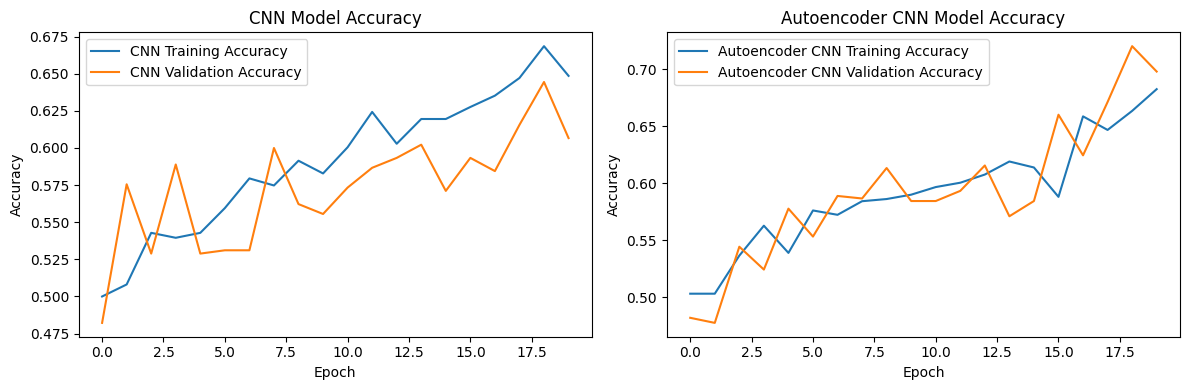

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(autoencoder_cnn_history.history['accuracy'], label='Autoencoder CNN Training Accuracy')
plt.plot(autoencoder_cnn_history.history['val_accuracy'], label='Autoencoder CNN Validation Accuracy')
plt.title('Autoencoder CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

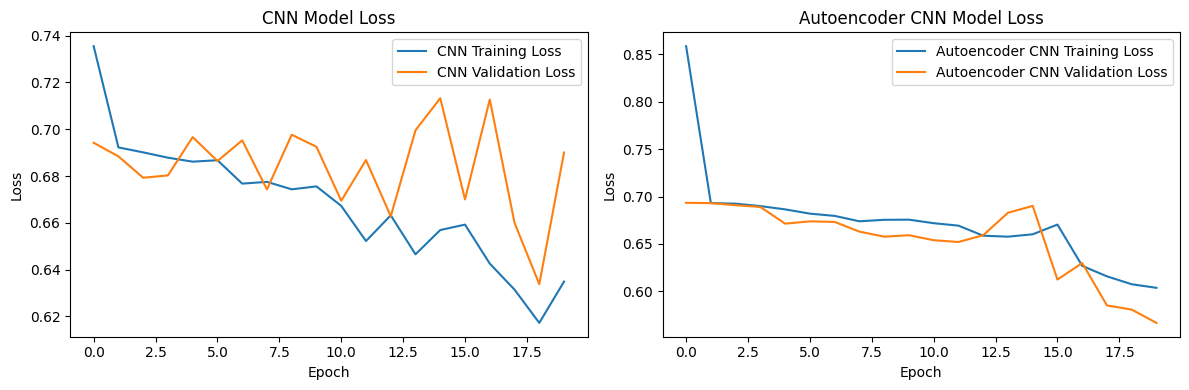

In [24]:

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(autoencoder_cnn_history.history['loss'], label='Autoencoder CNN Training Loss')
plt.plot(autoencoder_cnn_history.history['val_loss'], label='Autoencoder CNN Validation Loss')
plt.title('Autoencoder CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
# Evaluate CNN model on the test data
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test)
print("CNN Test Loss:", cnn_test_loss)
print("CNN Test Accuracy:", cnn_test_accuracy)

# Evaluate Autoencoder CNN model on the test data
autoencoder_cnn_test_loss, autoencoder_cnn_test_accuracy = autoencoder_cnn_model.evaluate(X_test, y_test)
print("Autoencoder CNN Test Loss:", autoencoder_cnn_test_loss)
print("Autoencoder CNN Test Accuracy:", autoencoder_cnn_test_accuracy)

15/15 [==============================] - 1s 84ms/step - loss: 0.7115 - accuracy: 0.5778
CNN Test Loss: 0.7114735245704651
CNN Test Accuracy: 0.5777778029441833
15/15 [==============================] - 1s 87ms/step - loss: 0.5893 - accuracy: 0.6689
Autoencoder CNN Test Loss: 0.5893402099609375
Autoencoder CNN Test Accuracy: 0.6688888669013977


15/15 [==============================] - 1s 83ms/step


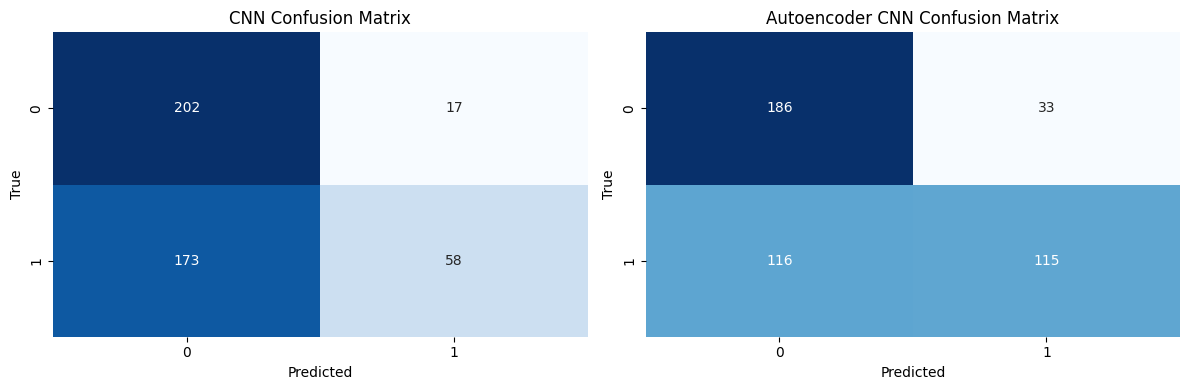

In [26]:
import seaborn as sns

# Generate predictions for CNN and Autoencoder CNN models
cnn_predictions = cnn_model.predict(X_test)
autoencoder_cnn_predictions = autoencoder_cnn_model.predict(X_test)

# Create confusion matrices and classification reports
cnn_confusion_matrix = confusion_matrix(y_test, cnn_predictions > 0.5)
autoencoder_cnn_confusion_matrix = confusion_matrix(y_test, autoencoder_cnn_predictions > 0.5)

# Plot confusion matrices
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('CNN Confusion Matrix')
sns.heatmap(cnn_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
plt.title('Autoencoder CNN Confusion Matrix')
sns.heatmap(autoencoder_cnn_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [27]:
# Classification reports
cnn_classification_report = classification_report(y_test, cnn_predictions > 0.5)
autoencoder_cnn_classification_report = classification_report(y_test, autoencoder_cnn_predictions > 0.5)

print("CNN Classification Report:\n", cnn_classification_report)
print("Autoencoder CNN Classification Report:\n", autoencoder_cnn_classification_report)

CNN Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.92      0.68       219
           1       0.77      0.25      0.38       231

    accuracy                           0.58       450
   macro avg       0.66      0.59      0.53       450
weighted avg       0.66      0.58      0.53       450

Autoencoder CNN Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.85      0.71       219
           1       0.78      0.50      0.61       231

    accuracy                           0.67       450
   macro avg       0.70      0.67      0.66       450
weighted avg       0.70      0.67      0.66       450

